# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [2]:
candidateno=291732 #this MUST be updated to your candidate number so that you get a unique data sample

In [3]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ozcel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ozcel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\ozcel\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [4]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [6]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['ingredients', ':', 'neophyte', 'lawyer', ',', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [8]:
#Preprocessing Steps
stop_words_list = stopwords.words('english')

def normalise_words(list):
    lowered_words=[word.lower() for word in list]
    filtered_words=[word for word in lowered_words if word.isalpha() and word not in stop_words_list]
    return filtered_words

training_data_norm=[(FreqDist(normalise_words(list)),label) for (list,label) in training_data]
testing_data_norm=[(FreqDist(normalise_words(list)),label) for (list,label) in testing_data]

print("training_data_norm sample: {}".format(training_data_norm[0]))
print("testing_data_norm sample: {}".format(testing_data_norm[0]))

#Calculating Frequency of Both Negative and Positive Words
pos_freq=FreqDist()
neg_freq=FreqDist()

for review,label in training_data_norm:
    if label=='pos':
        pos_freq+=review
    else:
        neg_freq+=review

#Automatically Generating Most Common Word List
def topk_frequent_words(posfreq,negfreq,threshold, topk=10):
    diff=posfreq-negfreq
    sorted_diff=diff.most_common()
    filtered=[(word,freq) for (word,freq) in sorted_diff if freq>threshold]
    topk_filtered=[word for (word, freq) in filtered[:topk]]
    return topk_filtered
    
positive_10words=topk_frequent_words(pos_freq,neg_freq,100)
negative_10words=topk_frequent_words(neg_freq,pos_freq,100)

print("10-most common positive words are: {}".format(positive_10words))
print("10-most common negative words are: {}".format(negative_10words))

training_data_norm sample: (FreqDist({'rudy': 11, 'movie': 7, 'lawyer': 4, 'legal': 3, 'insurance': 3, 'company': 3, 'law': 3, 'good': 3, 'situations': 2, 'corrupt': 2, ...}), 'pos')
testing_data_norm sample: (FreqDist({'tribe': 8, 'krippendorf': 6, 'shelmikedmu': 4, 'film': 4, 'seem': 3, 'however': 3, 'one': 3, 'professor': 3, 'kids': 3, 'humor': 3, ...}), 'pos')
10-most common positive words are: ['film', 'life', 'also', 'well', 'great', 'best', 'many', 'world', 'story', 'one']
10-most common negative words are: ['bad', 'movie', 'plot', 'even', 'like', 'nothing', 'worst', 'script', 'get', 'could']


Using the stopwords.words('english') command, a list of words that have no meaning in terms of analysis in English (such as punctuation, the, and, is) was obtained. Stopwords are usually removed from the dataset in such analysis studies because these words usually do not have a meaning on their own. These words were removed from the dataset to ensure that the model works with the correct words.

All letters in the words are converted to lower case with the normalise_words function. Then, a filter is applied to ensure that the words given as parameters to the function consist only of letters and do not contain stopwords. In this way, words with the same meaning can be analyzed more consistently. For example, the words 'bad' and 'Bad' are considered the same word.

Afterwards, the normalise_words function is applied on the training_data and testing_data datasets. In this way, the datasets are normalized and the stopwords are removed. Then, the frequency of use of each word in the relevant data group was measured with the FreqDist method on the dataset. In the model to be developed, frequency measurement has an important place in determining the critically important words that will play a role in the classification.

Following this, two objects named pos_freq and neg_freq were created to store the frequency of the words in positive and negative comments. The frequency of all words in the training data was calculated by grouping them based on labels. If the label of the word was positive, the calculated word-frequency pair was written to the pos_freq object; if it was negative, it was written to the neg_freq object. The frequency updated itself as appropriate words arrived in the loop thanks to the += operator. This stage has an important place in the training of the model because, for example, if a word is frequently used in negative comments, it may be an indicator that that word represents a negative emotion.

The most common words used in the positive and negative classes were determined with the topk_frequent_words function. In the function, the difference between the frequency of each word in positive data and the frequency in negative data is first calculated. Then, the calculated differences are sorted in decreasing order. The data is filtered according to the threshold determined to select meaningful words. Afterwards, the top 10 most frequently used words are selected with the top-k parameter. At this stage, it is calculated in which class a word is used more frequently. With the threshold value, rarely used, unnecessary or meaningless words are eliminated and words that have reached a certain frequency are taken into account. In this way, more reliable data is obtained for the development of the model.

2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [11]:
#Generating Classifier
class SimpleClassifier(ClassifierI):
    def __init__(self, pos_review, neg_review): 
        self._pos = pos_review 
        self._neg = neg_review 

    def classify(self, document): 
        score = 0        
        for word,value in document.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value        
        return "neg" if score < 0 else "pos"

    def labels(self): 
        return ("pos", "neg")

class SimpleClassifier_mf(SimpleClassifier):    
    def __init__(self,k):
        self._k=k
    
    def train(self,training_data):        
        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()
        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist
        self._pos=topk_frequent_words(pos_freq,neg_freq,self._k)
        self._neg=topk_frequent_words(neg_freq,pos_freq,self._k)


#Finding best fitting number-k
def finding_number_k(training, testing, numbers_k):
    ideal_k = None
    ideal_acc = 0.0

    for number in numbers_k:
        classifier_result = SimpleClassifier_mf(number)
        classifier_result.train(training)
        score_true = 0
        for comment, label in testing:
            if classifier_result.classify(comment) == label:
                score_true += 1                
        acc = score_true / len(testing_data)
        print(f"Accuracy for k={number}: {acc:.2f}")
        if acc >= ideal_acc:
            ideal_acc = acc
            ideal_k = number            
    print(f"\nBest k value: {ideal_k} with accuracy: {ideal_acc:.2f}")
    return ideal_k
k_values = range(50, 250, 50)
ideal_k = finding_number_k(training_data_norm, testing_data_norm, k_values)

#Applying Classifier, Training and Testing
movieclassifier=SimpleClassifier_mf(ideal_k)
m_train=movieclassifier.train(training_data_norm)
testing,true_labels=zip(*testing_data_norm)
predictions=movieclassifier.classify_many(testing)

#Generating dataframe with sentences, labels, and prediction 
def joining_words(dict):
    sentence = []
    for word, freq in dict.items():
        sentence.extend([word] * freq)
    return ' '.join(sentence)
sentences = [joining_words(sent_dict) for sent_dict in testing]

df = pd.DataFrame({
    'Sentence': sentences,
    'Label': true_labels,
    'Prediction': predictions
})

display(df)

Accuracy for k=50: 0.64
Accuracy for k=100: 0.64
Accuracy for k=150: 0.61
Accuracy for k=200: 0.60

Best k value: 100 with accuracy: 0.64


,Sentence,Label,Prediction
0,krippendorf krippendorf krippendorf krippendor...,pos,pos
1,june self taught idealistic yet pragmatic youn...,pos,pos
2,apparently director director tony tony tony ka...,pos,pos
3,one one one one colleagues surprised told will...,pos,pos
4,happy bastard second review notting notting hi...,pos,pos
...,...,...,...
595,michael michael crichton crichton crichton lon...,neg,pos
596,american american american american american p...,neg,pos
597,well going expect movie movie movie movie movi...,neg,neg
598,film extraordinarily horrendous going waste words,neg,pos


To classify positive and negative comments, 2 were created: SimpleClassifier and SimpleClassifier_mf. The working principle of SimpleClassifier is more superficial compared to SimpleClassifier_mf because it only makes a classification according to the labels in which the words in the sentence are dominant. According to the calculation, each word in the sentence is added or subtracted to the score account according to its frequency in pos_review or neg_review, and a final score is obtained. If the final score value is less than zero, the sentence is labeled as negative, if it is not less than zero, the sentence is labeled as positive. SimpleClassifier_mf, which inherits SimpleClassifier_mf, is a more detailed classification because there are training and testing stages in this classifier, so the classifier automatically creates the most frequently used word list. Its working principle is that all words in the data are written with their frequencies to pos_freq_dist and neg_freq_dist objects, and then critical words with emotional content are selected in the classification of comments with topk_frequent_words. Thus, the words to be used in training the model are determined in this way.

In SimpleClassifier_mf, it is critical how many critical words the model will classify because the k value to be applied can directly affect the accuracy rate of the model. In the finding_number_k function, all values ​​are trained in the model with increments of 50 from 50 to 250 and then applied to the test data and the accuracy calculation is made. The ideal k value is determined to be the largest k that gives the highest accuracy rate. This step is extremely important for the accuracy rate and performance of the model.

In order to examine the obtained predictions and real label values, a new dataframe was created with the sentence, label, and prediction columns. Since it was desired to examine only the words in the sentence in the sentence column, the words in each sentence were multiplied by the frequency with the joining_words function and then brought together. Then, a df table was created to visualize and examine the results.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [14]:
#Calculating metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, pos_label='pos')
recall = recall_score(true_labels, predictions, pos_label='pos')
f1 = f1_score(true_labels, predictions, pos_label='pos')

# Print the results
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")

pos_count = sum(1 for _, label in training_data_norm if label == 'pos')
print("training_data_norm 'pos' count:", pos_count)
print("training_data_norm 'neg' count:", len(training_data_norm)-pos_count)

Accuracy: 0.64167
Precision: 0.59770
Recall: 0.86667
F1 Score: 0.70748
training_data_norm 'pos' count: 700
training_data_norm 'neg' count: 700


The model accuracy is a very important factor in determining the model, however, it would be wrong to base the entire decision of the model on this factor alone, because the cost of error could be different depending on the case being analyzed, and thus other metrics besides accuracy would need to be taken into consideration. 

That is, if the model is designed to detect customer complaints about a service, then it is probably more important to detect negative comments, so the success of the model cannot be measured by the accuracy rate alone. For example, in this case, someone that would like to see how well the model is doing would be better off using the recall metric or the precision metric. Another thing besides all these, is that the spread of the data also affects how well the model will do, because the accurcy rate may not totally represent how well the model is doing if the data is not evenly distributed.

For example, 99% of the data set used in diagnosing an extremely rare disease is healthy, and only 1% of it is the actual disease. That model maybe 99% accurate with this data base, but if it can't find those few individuals with rare diseases then it has really failed as a model, in the sense that the model has no true estimation method. So, if the classes are balanced and the cost of a false positive error is approximately equal to the cost of a false negative error, then the accuracy metric can be a good measure of the performance of the model.

If we need to give an example of a scenario where the accuracy metric is a meaningful metric to measure the performance of the model, assuming that there is a system that separates email content as spam, and if there is half spam and half non-spam data in the data used for training, the accuracy metric can be used for model success because the distribution of the data set is regular and since the user can manually assign a different class in case of a wrong classification, there is no serious cost of wrong classification.

Back to the experiment that the model's being built on, the data distribution is even because there are 700 positive and 700 negative comments in the test data, and false positive and false negative error cost is the same. Therefore, the accuracy score is a significant factor for the overall performance of the model.

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

In [17]:
# Feature extractor function
from nltk.classify import NaiveBayesClassifier

def extract_features(review_dist):
    features = {}
    for word in positive_10words:
        features[f"contains({word})"] = (word in review_dist)
    for word in negative_10words:
        features[f"contains({word})"] = (word in review_dist)
    return features

# Prepare training and testing data for Naive Bayes classifier
training_nb_set = [(extract_features(reviewDist), label) for (reviewDist, label) in training_data_norm]
testing_nb_set = [(extract_features(reviewDist), label) for (reviewDist, label) in testing_data_norm]

# Training the Naive Bayes classifier
classifier = NaiveBayesClassifier.train(training_nb_set)
predictions_nb = [classifier.classify(features) for features, label in testing_nb_set]
true_labels_nb = [label for features, label in testing_nb_set]

# Calculate metrics
accuracy = accuracy_score(true_labels_nb, predictions_nb)
precision = precision_score(true_labels_nb, predictions_nb, pos_label='pos')
recall = recall_score(true_labels_nb, predictions_nb, pos_label='pos')
f1 = f1_score(true_labels_nb, predictions_nb, pos_label='pos')

# Print the results
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision (Positive): {precision:.5f}")
print(f"Recall (Positive): {recall:.5f}")
print(f"F1 Score (Positive): {f1:.5f}")

Accuracy: 0.71000
Precision (Positive): 0.70588
Recall (Positive): 0.72000
F1 Score (Positive): 0.71287


Accuracy: The ratio of correctly predicted data points to the total number of data points. While Word List Classifier has 64.2% Accuracy rate, Naive Bayes Classifier has 71.00% Accuracy rate. The data set has a balanced distribution. Therefore, when the general performance of the models is compared, Naive Bayes Classifier seems to work more effectively.

Precision: Shows the accuracy of the model's positive predictions. This value is 59.8% in Word List Classifier, while it is 70.6% in Naive Bayes Classifier. Considering the results, Word List Classifier is less successful in its positive predictions because only 59.8% of its positive predictions are correct. Naive Bayes Classifier works more successfully in positive predictions.

Recall: Reflects the ability to identify true positives. This metric is 86.7% in Word List Classifier. This is a very good rate. Word List Classifier is quite successful in remembering true positive data. Although Naive Bayes Classifier is not as successful as Word List Classifier, its recall rate is 72.00%. As can be seen from the figures, Naive Bayes Classifier has shown that it only misses a portion of the true positives.

F1 Score: Provides a balance between precision and recall metrics. Word List Classifier's F1 score is 0.70748. Similarly, Naive Bayes Classifier's F1 score is 0.71287. Both values ​​can be improved, but the current recall values ​​also show that there is a good agreement between precision and recall.

Although Word List Classifier's recall rate is quite good, its rate in other metrics is quite low. This shows that the model can only achieve success in some specific words. Therefore, this classifier works better only in some specific conditions. Naive Bayes Classifier has good values ​​in most of the metrics. It works with a better accuracy rate compared to Word List Classifier.

5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


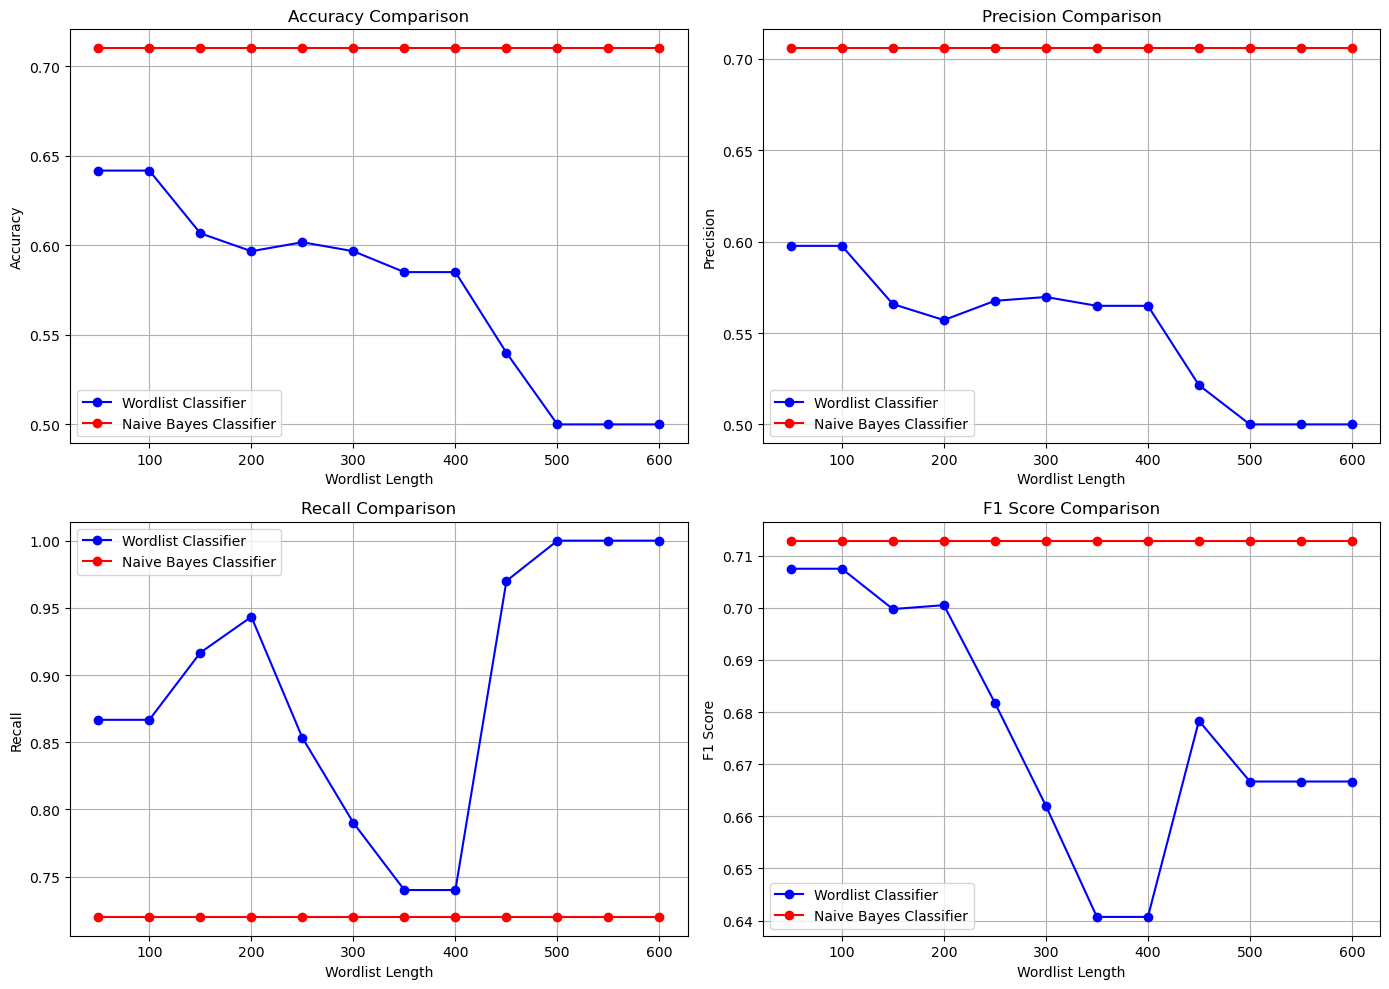

In [20]:
# Define wordlist lengths
wordlist_lengths = range(50, 650, 50)

# Lists to store metric results for both classifiers
acc_wordlist = []
prec_wordlist = []
recall_wordlist = []
f1_wordlist = []

acc_nb = []
prec_nb = []
recall_nb = []
f1_nb = []

# Loop through each wordlist length
for wordlist_length in wordlist_lengths:
    # Train and evaluate Wordlist-based classifier
    movieclassifier = SimpleClassifier_mf(wordlist_length)
    movieclassifier.train(training_data_norm)
    predictions_wordlist = [movieclassifier.classify(review) for review, label in testing_data_norm]
    
    # Calculate metrics for Wordlist Classifier
    acc_wordlist.append(accuracy_score(true_labels, predictions_wordlist))
    prec_wordlist.append(precision_score(true_labels, predictions_wordlist, pos_label='pos'))
    recall_wordlist.append(recall_score(true_labels, predictions_wordlist, pos_label='pos'))
    f1_wordlist.append(f1_score(true_labels, predictions_wordlist, pos_label='pos'))
    
    # Train and evaluate Naive Bayes classifier
    classifier = NaiveBayesClassifier.train(training_nb_set)
    predictions_nb = [classifier.classify(features) for features, label in testing_nb_set]
    
    # Calculate metrics for Naive Bayes Classifier
    acc_nb.append(accuracy_score(true_labels_nb, predictions_nb))
    prec_nb.append(precision_score(true_labels_nb, predictions_nb, pos_label='pos'))
    recall_nb.append(recall_score(true_labels_nb, predictions_nb, pos_label='pos'))
    f1_nb.append(f1_score(true_labels_nb, predictions_nb, pos_label='pos'))

# Plotting the results (2x2 matrix)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy plot
axes[0, 0].plot(wordlist_lengths, acc_wordlist, label='Wordlist Classifier', marker='o', color='blue')
axes[0, 0].plot(wordlist_lengths, acc_nb, label='Naive Bayes Classifier', marker='o', color='red')
axes[0, 0].set_xlabel('Wordlist Length')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Precision plot
axes[0, 1].plot(wordlist_lengths, prec_wordlist, label='Wordlist Classifier', marker='o', color='blue')
axes[0, 1].plot(wordlist_lengths, prec_nb, label='Naive Bayes Classifier', marker='o', color='red')
axes[0, 1].set_xlabel('Wordlist Length')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Recall plot
axes[1, 0].plot(wordlist_lengths, recall_wordlist, label='Wordlist Classifier', marker='o', color='blue')
axes[1, 0].plot(wordlist_lengths, recall_nb, label='Naive Bayes Classifier', marker='o', color='red')
axes[1, 0].set_xlabel('Wordlist Length')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Recall Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True)

# F1 Score plot
axes[1, 1].plot(wordlist_lengths, f1_wordlist, label='Wordlist Classifier', marker='o', color='blue')
axes[1, 1].plot(wordlist_lengths, f1_nb, label='Naive Bayes Classifier', marker='o', color='red')
axes[1, 1].set_xlabel('Wordlist Length')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True)

#Show Plots
plt.tight_layout()
plt.show()


Experiment Acceptances: The main purpose of this experiment is to determine the effect of the length of the word list on the Wordlist Classifier and Naive Bayes Classifier. In the experiment, training_data_norm was used to train the data and testing_data_norm was used to test the data. Each value was assigned as the length of the word list from 50 to 650, with 50 increments. In each increment, data is trained and tested by both classifiers and then metric measurements (Accuracy, Precision, Recall, F1 Score) are provided.

Experiment Outputs: In Wordlist Classifier, there is a steady decrease in the Accuracy rate as the length of the word list increases. Similarly, there is an almost continuous decrease in the precesion rate. The recall rate fluctuates throughout the relevant range but generally has high values. Since F1-score depends on the precision and recall metrics, there is a general decrease throughout the range. There is a sharp increase in the range of 400 - 500, but then a decrease occurs again. In all metrics, Naive Bayes Classifier consistently produced the same values ​​regardless of the length of the word list. Except for the recall metric, it produced better results than Wordlist Classifier in all other metrics regardless of the length of the word list. As a result, while the performance of the model generally decreases as the length of the word list increases in Wordlist Classifier, Naive Bayes Classifier produces more stable results regardless of the length of the word list and the model performance does not change.

My opinion: I would prefer to use Naive Bayes Classifier in my future studies because it produces better results in almost all metrics and since the performance of the model does not depend on the length of the word list, it produces more reliable results. Wordlist Classifier may experience performance loss in long word lists and may produce unreliable results. Therefore, In my opinion, Naive Bayes Classifier is a better option for my future studies.

In [33]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current
filepath = r"C:\Users\ozcel\Desktop\Term1_Courses\02_AppliedNaturalLanguageProcessing\ANLPassignment2024.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1812
